# ENCH 470 Drug Repurposing Project Logistic Regression
### The Bigfoots - Natalie Dame, Taylor deSilva, Madison McLaren
The following document are the results of the logistic regression model that was developed to classify drugs as active or inactive based on their molecular structures.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

## 5-HT Receptor Target - Ki Data
For this project, our goal was to develop a model that could classify drugs as based on their ability to inhibit the 5-HT receptor. To do this, the ChEMBL Database was used to find molecules that targeted the receptor. Specifically, molecules that had Ki values related to the 5-HT receptor were used. Ki is the inhibition constant that describes the likelihood of an inhibitor to dissociate from the target receptor. For our project, a lower value of Ki is desirable since it corresponds to a higher chance of inhibition.

In [2]:
#Extract values from CSV file
df5HT_Ki_ChEMBL = pd.read_csv('5HT_Ki.csv', sep = ';')

#Drop unwanted columns from the dataframe
df5HT_Ki_ChEMBL.drop(['Molecule Name','Assay Organism','Document ChEMBL ID','Target Type','Source ID','Document Journal','BAO Format ID','Target ChEMBL ID','Target Name','Target Organism','Standard Relation','AlogP','Data Validity Comment','Uo Units','Comment','Molecule Max Phase','BAO Label','Assay Tissue ChEMBL ID','Assay Tissue Name','Assay Cell Type','Assay Subcellular Fraction', '#RO5 Violations','Compound Key','Source Description','Document Year','Cell ChEMBL ID','Properties','Assay Parameters','Assay Variant Accession','Assay Variant Mutation'], axis=1, inplace=True)

#Remove any duplicate molecules from the dataframe based on ChEMBL ID
df5HT_Ki_ChEMBL.drop_duplicates(subset=['Smiles'], keep=False, inplace=True)

#Remove any rows whose Ki values return NaN
df5HT_Ki_ChEMBL = df5HT_Ki_ChEMBL[df5HT_Ki_ChEMBL['Standard Value'].notna()]

#Reindex the Dataframe
df5HT_Ki_ChEMBL.reset_index(drop=True, inplace=True)
df5HT_Ki_ChEMBL

,Molecule ChEMBL ID,Molecular Weight,Smiles,Standard Type,Standard Value,Standard Units,pChEMBL Value,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type
0,CHEMBL110601,553.66,COc1ccc(NCC(=O)N2CCN(c3ccccc3C)CC2)cc1N1CCN(C)...,Ki,40.00,nM,7.40,16.91,0.32,4.88,14.42,0,CHEMBL616433,Affinity for 5-hydroxytryptamine 1B receptor s...,B
1,CHEMBL190190,400.53,Cc1ccc2c(OCCN3CCN(Cc4cccc5cc[nH]c45)CC3)cccc2n1,Ki,398.11,nM,6.40,15.98,0.29,2.18,14.42,0,CHEMBL839747,Displacement of [3H]5-HT from human 5-hydroxyt...,B
2,CHEMBL423127,451.61,CCCN(CCCCN1C(=O)CC(C)(C)CC1=O)C1CCc2ccc3[nH]cc...,Ki,115.00,nM,6.94,15.37,0.29,2.43,9.44,0,CHEMBL616870,In vitro binding affinity against cloned mamma...,B
3,CHEMBL197947,517.64,CCc1c(C(=O)N2CCc3cc4ccnc(N5CCN6CCC[C@@H]6C5)c4...,Ki,1.00,nM,9.00,17.39,0.32,4.66,11.07,0,CHEMBL883691,Mean binding affinity towards 5-hydroxytryptam...,B
4,CHEMBL79693,414.55,NC(=O)c1ccc2c(c1)CCOC2CCN1CCC(c2cccc3ccccc23)CC1,Ki,73.00,nM,7.14,17.22,0.31,2.32,12.84,0,CHEMBL616528,Binding affinity towards human 5-hydroxytrypta...,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,CHEMBL4871980,246.29,Fc1ccc(-c2n[nH]cc2N2CCNCC2)cc1,Ki,10000.00,nM,NaN,NaN,NaN,NaN,NaN,0,CHEMBL4828355,Binding affinity to 5HT1B receptor (unknown or...,B
975,CHEMBL4856702,246.29,Fc1cccc(-c2n[nH]cc2N2CCNCC2)c1,Ki,1819.00,nM,5.74,23.31,0.44,4.11,13.06,0,CHEMBL4828355,Binding affinity to 5HT1B receptor (unknown or...,B
976,CHEMBL4869695,260.32,Fc1ccc(-c2n[nH]cc2N2CCCNCC2)cc1,Ki,10000.00,nM,NaN,NaN,NaN,NaN,NaN,0,CHEMBL4828355,Binding affinity to 5HT1B receptor (unknown or...,B
977,CHEMBL4876193,256.35,Cc1cccc(-c2n[nH]cc2N2CCCNCC2)c1,Ki,10000.00,nM,NaN,NaN,NaN,NaN,NaN,0,CHEMBL4828355,Binding affinity to 5HT1B receptor (unknown or...,B


## Develop Active and Inactive Molecule Dataframes
The next step is to split the dataset into Active and Inactive datasets. In order to do this, a threshold value for Ki must be chosen. Based off a literature source, we found that stated "The results also suggested that the threshold Ki value which could separate 5-HT uptake inhibitors with a probable long-lasting effect in vivo from those without the effect would be between 5 nM and 42 nM" (Ishigooka J, 1998). Thus, we decided to classify molecules with a Ki < 42 as active

#### Active Molecules

In [3]:
ActiveDrugs = df5HT_Ki_ChEMBL[(df5HT_Ki_ChEMBL["Standard Value"] < 42)]
ActiveDrugs.reset_index(drop=True, inplace=True)
ActiveDrugs

,Molecule ChEMBL ID,Molecular Weight,Smiles,Standard Type,Standard Value,Standard Units,pChEMBL Value,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type
0,CHEMBL110601,553.66,COc1ccc(NCC(=O)N2CCN(c3ccccc3C)CC2)cc1N1CCN(C)...,Ki,40.000,nM,7.40,16.91,0.32,4.88,14.42,0,CHEMBL616433,Affinity for 5-hydroxytryptamine 1B receptor s...,B
1,CHEMBL197947,517.64,CCc1c(C(=O)N2CCc3cc4ccnc(N5CCN6CCC[C@@H]6C5)c4...,Ki,1.000,nM,9.00,17.39,0.32,4.66,11.07,0,CHEMBL883691,Mean binding affinity towards 5-hydroxytryptam...,B
2,CHEMBL1242257,536.68,Cc1ccc2c(N3CCN(CCc4cccc5c4OCc4c(C(=O)NC6CCCC6)...,Ki,1.995,nM,8.70,NaN,NaN,NaN,NaN,0,CHEMBL1248646,Antagonist activity against human recombinant ...,F
3,CHEMBL372743,491.60,CCc1c(C(=O)N2CCc3cc4ccnc(N5CCN(C)CC5)c4cc32)cn...,Ki,1.000,nM,9.00,18.31,0.33,5.19,11.07,0,CHEMBL883691,Mean binding affinity towards 5-hydroxytryptam...,B
4,CHEMBL111316,229.28,NC(=O)c1ccc2[nH]c3c(c2c1)CC(N)CC3,Ki,10.000,nM,8.00,34.89,0.64,6.92,9.42,0,CHEMBL617321,Displacement of [3H]-5-HT from human 5-hydroxy...,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,CHEMBL340786,458.61,Cc1ccccc1N1CCN(C(=O)COc2ccc3cccc(N4CCN(C)CC4)c...,Ki,0.300,nM,9.52,20.76,0.38,5.89,24.26,0,CHEMBL616431,Receptor binding affinity for cloned human 5-h...,B
372,CHEMBL458199,458.65,Cc1ccc2c(OCCN3CCC(Cc4cccc(N5CCN(C)CC5)c4)CC3)c...,Ki,6.310,nM,8.20,17.88,0.33,3.57,25.75,0,CHEMBL1035841,Displacement of [3H]5HT from human 5HT1B recep...,B
373,CHEMBL330603,488.57,Cn1nnnc1-c1ccc2c(c1)c(C1CCN(CCN3CCNC3=O)CC1)cn...,Ki,20.000,nM,7.70,15.76,0.29,4.54,9.15,0,CHEMBL616962,Ability to displace [3H]5-CT (1.5 nM) from HeL...,B
374,CHEMBL431866,444.58,COc1ccc(NC(=O)N2CC=C(c3ccc4[nH]cc(C[C@H]5CCCN5...,Ki,4.200,nM,8.38,18.84,0.35,3.25,13.82,0,CHEMBL616534,Binding affinity towards cloned human 5-hydrox...,B


#### Inactive Molecules

In [4]:
InactiveDrugs = df5HT_Ki_ChEMBL[(df5HT_Ki_ChEMBL["Standard Value"] > 42)]
InactiveDrugs.reset_index(drop=True, inplace=True)
InactiveDrugs

,Molecule ChEMBL ID,Molecular Weight,Smiles,Standard Type,Standard Value,Standard Units,pChEMBL Value,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type
0,CHEMBL190190,400.53,Cc1ccc2c(OCCN3CCN(Cc4cccc5cc[nH]c45)CC3)cccc2n1,Ki,398.11,nM,6.40,15.98,0.29,2.18,14.42,0,CHEMBL839747,Displacement of [3H]5-HT from human 5-hydroxyt...,B
1,CHEMBL423127,451.61,CCCN(CCCCN1C(=O)CC(C)(C)CC1=O)C1CCc2ccc3[nH]cc...,Ki,115.00,nM,6.94,15.37,0.29,2.43,9.44,0,CHEMBL616870,In vitro binding affinity against cloned mamma...,B
2,CHEMBL79693,414.55,NC(=O)c1ccc2c(c1)CCOC2CCN1CCC(c2cccc3ccccc23)CC1,Ki,73.00,nM,7.14,17.22,0.31,2.32,12.84,0,CHEMBL616528,Binding affinity towards human 5-hydroxytrypta...,B
3,CHEMBL2205825,295.38,COc1ccc(CN2C3C4C5CC6C7C5C3C7C2(O)C64)cc1,Ki,10000.00,nM,NaN,NaN,NaN,NaN,NaN,0,CHEMBL2215549,Binding affinity to 5-HT1B receptor,B
4,CHEMBL458001,500.00,O=C(Nc1cccc(Cn2ncc(N3CCNCC3)c(Cl)c2=O)c1)c1ccc...,Ki,524.81,nM,6.28,12.56,0.24,2.01,7.92,0,CHEMBL991387,Displacement of [3H]5HT from 5HT1B receptor ex...,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,CHEMBL4871980,246.29,Fc1ccc(-c2n[nH]cc2N2CCNCC2)cc1,Ki,10000.00,nM,NaN,NaN,NaN,NaN,NaN,0,CHEMBL4828355,Binding affinity to 5HT1B receptor (unknown or...,B
599,CHEMBL4856702,246.29,Fc1cccc(-c2n[nH]cc2N2CCNCC2)c1,Ki,1819.00,nM,5.74,23.31,0.44,4.11,13.06,0,CHEMBL4828355,Binding affinity to 5HT1B receptor (unknown or...,B
600,CHEMBL4869695,260.32,Fc1ccc(-c2n[nH]cc2N2CCCNCC2)cc1,Ki,10000.00,nM,NaN,NaN,NaN,NaN,NaN,0,CHEMBL4828355,Binding affinity to 5HT1B receptor (unknown or...,B
601,CHEMBL4876193,256.35,Cc1cccc(-c2n[nH]cc2N2CCCNCC2)c1,Ki,10000.00,nM,NaN,NaN,NaN,NaN,NaN,0,CHEMBL4828355,Binding affinity to 5HT1B receptor (unknown or...,B


## Logistic Regression Modelling
The next step was to develop the logistic regression model. As stated previously, the labels would be active (1) or inactive (0) and the features would be the fingerprints that are generated based on the molecular structure.

#### Develop Fingerprints for Active and Inactive Molecules

In [5]:
# Create list of Smiles Strings for Active and Inactive Drugs
ActiveMolecules_Smiles = ActiveDrugs['Smiles'].tolist()
InactiveMolecules_Smiles = InactiveDrugs['Smiles'].tolist()

# Make a list of Molecule Objects
ActiveMolecules = [Chem.MolFromSmiles(i) for i in ActiveMolecules_Smiles]
InactiveMolecules = [Chem.MolFromSmiles(i) for i in InactiveMolecules_Smiles]

# Fingerprints for active molecules
ActiveFingerprints = rdFingerprintGenerator.GetFPs(ActiveMolecules)

# Fingerprints for inactive molecules
InactiveFingerprints = rdFingerprintGenerator.GetFPs(InactiveMolecules)

# Concatenate fingerprints
Fingerprints = ActiveFingerprints + InactiveFingerprints

#### Assign Classification

In [6]:
# 'Active' = 1
y_Active = np.ones(len(ActiveFingerprints))

# 'Inactive' = 0
y_Inactive = np.zeros(len(InactiveFingerprints))

# Classifier
y = np.concatenate([y_Active, y_Inactive])

#### Split Data into Train and Test Sets

In [7]:
# 30% for testing, 70% for training
X_train, X_test, y_train, y_test = train_test_split(Fingerprints, y, test_size=0.30)

#### Train Model

In [8]:
# Initialize the model 
clf = LogisticRegression(random_state=0, max_iter=1000)

# Fit the model
clf.fit(X_train,y_train)

# Make Predictions based on Train Data
y_train_pred = clf.predict(X_train)

# See how Well Model Performed
Train_score = clf.score(X_train,y_train)
print('The Train Score is:',Train_score)

The Train Score is: 0.9854014598540146


#### Test Performance of the Model

In [9]:
# Predict on the Model using Test Set
y_test_pred = clf.predict(X_test)

Test_score = clf.score(X_test,y_test)
print('The Test Score is:',Test_score)

# The confusion matrix shows false positives and false negatives
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test,y_test_pred, labels = [1, 0]))

The Test Score is: 0.8945578231292517
Confusion matrix:
[[100  18]
 [ 13 163]]


### Determine which Bits had the Highest and Lowest Weights for the Model
The three highest positive weights correspond to the three features that have the most impact on a molecule being classified as Active, and the three lowest negative weights correspond to the three features that have the most impact on a molecule bing classified as Inactive.

In [10]:
# Capture the top 3 positive and top 3 negative weights 
# Create Empty Lists
maxs = [] # maxs will hold the top three most positive weights
mins = [] # mins will hold the top three most negative weights
maxindices = [] # maxindicies will return the fingerprint indicie of the max positive weights
minindices = [] # minindicies will return the fingerprint indicie of the min positive weights

# Return coefficients from the model and transpose them
coefs = clf.coef_.T
# Convert coefficients from array to list
coefs = np.ndarray.tolist(coefs)
# Create a loop that finds the top 3 positive and top 3 negative weights
for i in range(3):
    currmin = 0 # set an arbitraty value for max weight
    currmax = 0 # set an arbitraty value for min weight
    minindex = 0 # set an arbitraty value for max index
    maxindex = 0 # set an arbitraty value for min index
    for j in range(len(coefs)):
        if coefs[j][0] > currmax:
            currmax = coefs[j][0] # Replace max weight with new weight
            maxindex = j
        if coefs[j][0] < currmin:
            currmin = coefs[j][0] # Replace min weight with new weight
            minindex = j
    coefs.remove([currmax])
    coefs.remove([currmin])
    maxs.append((currmax, maxindex))
    mins.append((currmin, minindex))
    maxindices.append(maxindex)
    minindices.append(minindex)
    
# Output the max and min weights and indices
print("Top 3 max weights and their fingerprint features:", maxs, end='\n\n')
print("Top 3 min weights and their fingerprint features:", mins, end='\n\n')

Top 3 max weights and their fingerprint features: [(1.1018245417789947, 218), (1.0535899725965385, 1094), (1.0523200247140396, 678)]

Top 3 min weights and their fingerprint features: [(-1.1608090054411444, 430), (-0.8656218024859308, 1789), (-0.7555076795516924, 321)]



## Check Train Set for Active and Inactive Molecules containing Max and Min weighted Features
#### Classify train molecules as active or inactive

In [11]:
# Convert train labels to list
y_train_list = y_train.tolist()

# Create a list that matches features to labels
Train_Data = list(zip(X_train, y_train_list))

# Create empty lists for active and inactive train data
TrainActive = []
TrainInactive = []

# If the label is a 1, put in the TrainActive list
# If the label is a 0, put in the TrainInactive list
for i in range(len(Train_Data)):
    if Train_Data[i][1] == 1:
        TrainActive.append(Train_Data[i][0])
    if Train_Data[i][1] == 0:
        TrainInactive.append(Train_Data[i][0])

#### Verify what active/inactive molecules contain the highest/lowest weighted features

In [13]:
# List of lists where...
# Determine active and inactive molecules that contain highest postiive weights
train_positive_active_indices = [[], [], []] #[0] corresponds to highest positive weight
train_positive_inactive_indices = [[], [], []]

# Determine active and inactive molecules that contain lowest negative weights
train_negative_active_indices = [[], [], []] #[0] corresponds to lowest negative weight
train_negative_inactive_indices = [[], [], []]

for i in range(len(TrainActive)):
    # Make bit strings from the fingerprints to check for a 1
    actString = TrainActive[i].ToBitString()
    
    for j in range(len(maxs)):
        # Check for the highest positive feature
        _, max_index = maxs[j]
        _, min_index = mins[j]
        if actString[max_index] == '1':
            train_positive_active_indices[j].append(i)
        # Check for the lowest negative feature
        if actString[min_index] == '1':
            train_positive_inactive_indices[j].append(i)
            
for i in range(len(TrainInactive)):
    # Make bit strings from the fingerprints to check for a 1
    inactString = TrainInactive[i].ToBitString()
    
    for j in range(len(maxs)):
        # Check for the highest positive feature
        _, max_index = maxs[j]
        _, min_index = mins[j]
        if inactString[max_index] == '1':
            train_negative_active_indices[j].append(i)
        # Check for the lowest negative feature
        if inactString[min_index] == '1':
            train_negative_inactive_indices[j].append(i)
        
# Output findings
print("The number of Active Molecules that have the feature with the highest positive weights:")
print("Highest Weight:",len(train_positive_active_indices[0]))
print("Second Highest Weight:",len(train_positive_active_indices[1]))
print("Third Highest Weight:",len(train_positive_active_indices[2]))
print()
print("The number of Active Molecules that have the feature with the lowest negative weights:")
print("Lowest Weight:",len(train_negative_active_indices[0]))
print("Second Lowest Weight:",len(train_negative_active_indices[1]))
print("Third Lowest Weight:",len(train_negative_active_indices[2]))
print()
print("The number of Inactive Molecules that have the feature with the highest positive weights:")
print("Highest Weight:",len(train_positive_inactive_indices[0]))
print("Second Highest Weight:",len(train_positive_inactive_indices[1]))
print("Third Highest Weight:",len(train_positive_inactive_indices[2]))
print()
print("The number of Inactive Molecules that have the feature with the lowest negative weights:")
print("Lowest Weight:",len(train_negative_inactive_indices[0]))
print("Second Lowest Weight:",len(train_negative_inactive_indices[1]))
print("Third Lowest Weight:",len(train_negative_inactive_indices[2]))

The number of Active Molecules that have the feature with the highest positive weights:
Highest Weight: 78
Second Highest Weight: 1
Third Highest Weight: 3

The number of Active Molecules that have the feature with the lowest negative weights:
Lowest Weight: 23
Second Lowest Weight: 1
Third Lowest Weight: 9

The number of Inactive Molecules that have the feature with the highest positive weights:
Highest Weight: 0
Second Highest Weight: 0
Third Highest Weight: 0

The number of Inactive Molecules that have the feature with the lowest negative weights:
Lowest Weight: 8
Second Lowest Weight: 1
Third Lowest Weight: 1


#### Match Active Train Molecules to Overall Active Molecules Set

In [14]:
TrainActiveindices = []
AllActiveindices = []
for i in range(len(TrainActive)):
    for j in range(len(ActiveFingerprints)):
        if TrainActive[i] == ActiveFingerprints[j] and i not in TrainActiveindices:
            TrainActiveindices.append(i)
            AllActiveindices.append(j)

#### Draw Bits that have Highest Postitive Weights

[74, 80, 104, 218, 231, 260, 289, 310, 314, 378, 389, 407, 441, 609, 650, 656, 690, 762, 840, 873, 875, 926, 935, 971, 1035, 1039, 1057, 1060, 1088, 1097, 1114, 1126, 1145, 1243, 1290, 1295, 1357, 1380, 1452, 1480, 1482, 1508, 1535, 1575, 1646, 1647, 1655, 1708, 1722, 1750, 1754, 1774, 1791, 1798, 1855, 1873, 1905, 1965, 1982, 2020]


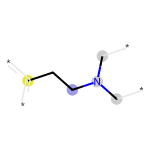

In [15]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(ActiveMolecules[AllActiveindices[train_positive_active_indices[0][0]]], radius=2, bitInfo=bi)
print(list(fp.GetOnBits()))
Draw.DrawMorganBit(ActiveMolecules[AllActiveindices[train_positive_active_indices[0][0]]],maxindices[0],bi)

[67, 80, 165, 249, 260, 294, 299, 352, 378, 394, 407, 552, 607, 623, 650, 680, 695, 734, 739, 794, 807, 820, 841, 868, 875, 926, 935, 958, 980, 1002, 1019, 1039, 1057, 1088, 1094, 1142, 1145, 1181, 1199, 1203, 1236, 1259, 1295, 1309, 1357, 1380, 1384, 1387, 1401, 1480, 1504, 1536, 1573, 1659, 1673, 1722, 1731, 1738, 1750, 1851, 1855, 1873, 1888, 1892, 1895, 1911, 1917, 1970, 1991]


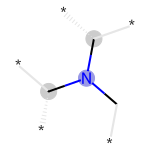

In [16]:
bi1 = {}
fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(ActiveMolecules[AllActiveindices[train_positive_active_indices[1][0]]], radius=2, bitInfo=bi1)
print(list(fp1.GetOnBits()))
Draw.DrawMorganBit(ActiveMolecules[AllActiveindices[train_positive_active_indices[1][0]]],maxindices[1],bi1)

[80, 98, 106, 222, 256, 352, 369, 378, 383, 553, 675, 678, 714, 807, 984, 999, 1019, 1057, 1088, 1199, 1309, 1380, 1397, 1443, 1516, 1602, 1607, 1750, 1831, 1861, 1873, 1905]


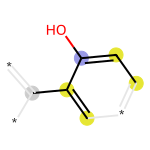

In [17]:
bi2 = {}
fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(ActiveMolecules[AllActiveindices[train_positive_active_indices[2][0]]], radius=2, bitInfo=bi2)
print(list(fp2.GetOnBits()))
Draw.DrawMorganBit(ActiveMolecules[AllActiveindices[train_positive_active_indices[2][0]]],maxindices[2],bi2)

## Compare with Approved Drug Molecules
https://www.frontiersin.org/articles/10.3389/fpsyt.2020.595584/full

In [18]:
Olanzapine_df = pd.read_csv('Olanzapine.csv', sep = ';')
Olanzapine = pd.DataFrame(Olanzapine_df.iloc[1]).T
Aripiprazole_df = pd.read_csv('Aripiprazole.csv', sep = ';')
Aripiprazole = pd.DataFrame(Aripiprazole_df.iloc[1]).T
Risperidone_df = pd.read_csv('Risperidone.csv', sep = ';')
Risperidone = pd.DataFrame(Risperidone_df.iloc[0]).T
ApprovedDrugs = pd.concat([Aripiprazole, Olanzapine, Risperidone], ignore_index=True)
ApprovedDrugs

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,Smiles,Inchi Key
0,CHEMBL1112,ARIPIPRAZOLE,ABILIFY MAINTENA|ABILIFY MAINTENA KIT|ABILIFY ...,Small molecule,4.0,448.39,112.0,661.0,4.86,44.81,...,30,5,1,0,447.148,-1.16,NEUTRAL,C23H27Cl2N3O2,O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1,CEUORZQYGODEFX-UHFFFAOYSA-N
1,CHEMBL715,OLANZAPINE,ARKOLAMYL|LY-170053|LY170053|OLANSEK|OLANZAPIN...,Small molecule,4.0,312.44,186.0,1275.0,3.44,30.87,...,22,4,1,0,312.1409,-0.99,NEUTRAL,C17H20N4S,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1,KVWDHTXUZHCGIO-UHFFFAOYSA-N
2,CHEMBL85,RISPERIDONE,LY-03004|LY03004|N05AX08|NSC-759895|PERSERIS|P...,Small molecule,4.0,410.49,213.0,1366.0,3.59,64.16,...,30,6,0,0,410.2118,-1.47,BASE,C23H27FN4O2,Cc1nc2n(c(=O)c1CCN1CCC(c3noc4cc(F)ccc34)CC1)CCCC2,RAPZEAPATHNIPO-UHFFFAOYSA-N


#### Generate Fingerprints for Approved Anxiety Drugs

In [27]:
# Create list of Smiles Strings for Approved Drugs
ApprovedDrugs_smiles = ApprovedDrugs['Smiles'].tolist()

# Make a list of Molecule Objects
ApprovedDrugs_molecules = [Chem.MolFromSmiles(i) for i in ApprovedDrugs_smiles]

# Fingerprints for approved drugs
ApprovedDrugs_fingerprints = rdFingerprintGenerator.GetFPs(ApprovedDrugs_molecules)

#### Run the Logistic Regression Model with the Approved Drugs

In [28]:
y_Approvedtest = clf.predict(ApprovedDrugs_fingerprints)
y_test_prob = clf.predict_proba(ApprovedDrugs_fingerprints)
print("Results for Approved Drugs:",y_Approvedtest)

Results for Approved Drugs: [0. 0. 1.]


#### Determine if Approved Drugs have the Features with the Highest Positive Weights

In [31]:
# list of lists where indices[0] holds all of the indices with the max weight, induces[1] holds indices with second...
positive_active_indices = [[], [], []]
negative_active_indices = [[], [], []]

for i in range(len(ApprovedDrugs_fingerprints)):
    # Make bit strings from the fingerprints to check for a 1
    appString = ApprovedDrugs_fingerprints[i].ToBitString()
    
    for j in range(len(maxs)):
        # Check for the highest positive feature
        _, max_index = maxs[j]
        _, min_index = mins[j]
        if appString[max_index] == '1':
            positive_active_indices[j].append(i)

        # Check for the lowest negative feature
        if appString[min_index] == '1':
            negative_active_indices[j].append(i)
print("Highest Weight:",positive_active_indices[0])
print("Second Highest Weight:",positive_active_indices[1])
print("Third Highest Weight:",positive_active_indices[2])

Highest Weight: [2]
Second Highest Weight: []
Third Highest Weight: []


#### Show that Risperidone has the Feature with the Highest Postive Weight

[30, 63, 80, 92, 112, 218, 248, 265, 310, 314, 378, 421, 504, 622, 630, 642, 650, 656, 699, 802, 875, 885, 926, 935, 987, 1019, 1028, 1057, 1115, 1129, 1145, 1193, 1203, 1243, 1261, 1325, 1357, 1380, 1398, 1410, 1463, 1480, 1482, 1487, 1496, 1542, 1580, 1652, 1670, 1722, 1733, 1738, 1750, 1791, 1808, 1855, 1873, 1928, 1998, 2000, 2034]


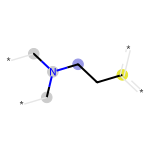

In [25]:
bi6 = {}
fp6 = rdMolDescriptors.GetMorganFingerprintAsBitVect(ApprovedDrugs_molecules[positive_active_indices[0][0]], radius=2, bitInfo=bi6)
print(list(fp6.GetOnBits()))
Draw.DrawMorganBit(ApprovedDrugs_molecules[positive_active_indices[0][0]],maxindices[0],bi6)